In [1]:
%pylab inline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


(512, 512)


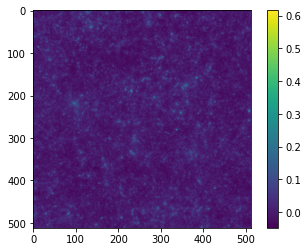

In [2]:
ktng_map = np.load('ktng_map.npy')
print(ktng_map.shape)
imshow(ktng_map)
colorbar()

### Compute the power spectrum of a convergence map

In [3]:
import numpy as np

def radial_profile(data):
    """
    Compute the radial profile of 2d image
    :param data: 2d image
    :return: radial profile
    """
    center = data.shape[0]/2
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center)**2 + (y - center)**2)
    r = r.astype('int32')

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile

def measure_power_spectrum(map_data, pixel_size):
    """
    measures power 2d data
    :param map_data: map (n x n)
    :param pixel_size: pixel size (rad/pixel)
    :return: ell
    :return: power spectrum
    """
    data_ft = np.fft.fftshift(np.fft.fft2(map_data)) / map_data.shape[0]
    nyquist = np.int(map_data.shape[0]/2)
    power_spectrum = radial_profile(np.real(data_ft*np.conj(data_ft)))[:nyquist]
    power_spectrum *= pixel_size**2

    k = np.arange(power_spectrum.shape[0])
    ell = 2. * np.pi * k / pixel_size / map_data.shape[0]

    return ell, power_spectrum

In [4]:
resolution = 0.29 # pixel resolution: 0.29 arcmin/pixel
pixel_size = np.pi * resolution / 180. / 60. #rad/pixel

#ell = 2. * np.pi * k / pixel_size / 512
ell, ps_example = measure_power_spectrum(ktng_map, pixel_size)

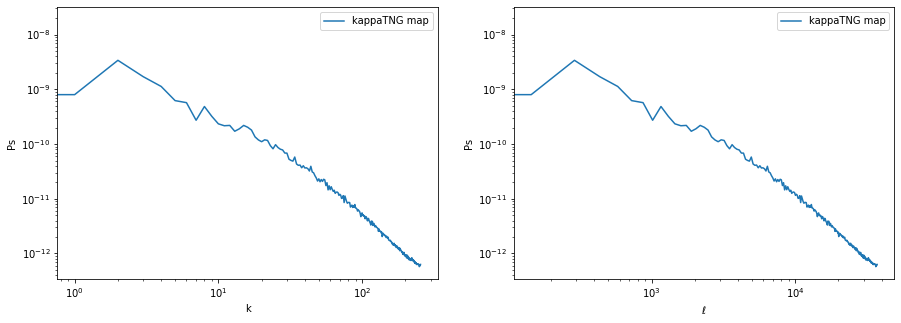

In [5]:
figure(figsize=(15,5))
subplot(121)
k = np.arange(ps_example.shape[0])
plt.loglog(k, ps_example, label='kappaTNG map')
xlabel('k')
ylabel('Ps')
legend()
 
subplot(122)
plt.loglog(ell, ps_example, label='kappaTNG map')
xlabel('$\ell$')
ylabel('Ps')
legend()

### Compute the theoretical power spectrum of a convergence map

In [6]:
#!pip install --quiet jax-cosmo

In [7]:
import jax
import jax.numpy as np
import jax_cosmo as jc

In [8]:
z_array = np.load('z_array.npy')
pz_array=np.load('pz_array.npy')

In [9]:
nzs_s=jc.redshift.kde_nz(z_array, pz_array,bw=0.011)

/opt/anaconda3/envs/cosmo/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


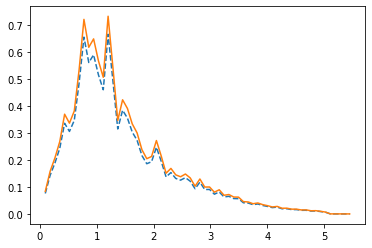

In [10]:
plot(z_array, nzs_s(z_array)/3.3894885098234955, '--')
plot(z_array, pz_array/0.08474322956787046)

In [11]:
nzs=[nzs_s]
probes = [ jc.probes.WeakLensing(nzs, sigma_e=0.26) ]

In [12]:
elle = np.logspace(1,5) # Defines a range of \ell
cosmo = jc.Planck15()
# And compute the data vector
cls = jc.angular_cl.angular_cl(cosmo, elle, probes)

/opt/anaconda3/envs/cosmo/lib/python3.8/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/opt/anaconda3/envs/cosmo/lib/python3.8/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/opt/anaconda3/envs/cosmo/lib/python3.8/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <cl

### Compare theoretical and measured power spectrum

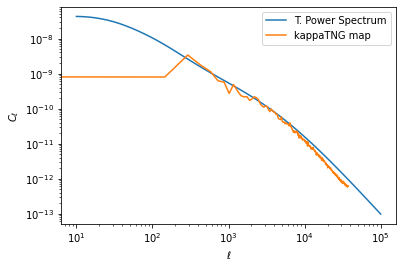

In [13]:
loglog(elle, cls[0], label='T. Power Spectrum')
loglog(ell, ps_example, label='kappaTNG map')
xlabel('$\ell$')
ylabel('$C_\ell$')
legend()